## Applying NLP Techniques to Assess Comments and Extract Patterns/Statistics

### Objective: To explore comments, extract possible POS Tag patterns and create train and test set

### Importing Required Packages

In [272]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter
import requests
import datetime

from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import wordnet

import re

### Uses of Various Lists in this code
#### List a for storing number of sentences of each comments
#### List b for storing storing pos tag of each word in the sentences
#### List c for storing the comment id in the order of occurrence
#### List d for storing the pos tag of sentences as sentence format itself
#### List helper is used for recording the sentence, the comment it is related to and the index of the sentence as in the order of being read
#### List sents contains the the tokenized sentences of each comment in one iteration
#### List text contains the words tokenized by nltk per comment
#### List all_sents contains all the sentences that have been tokenized by nltk
#### List pos_tagged_sent_without_BK contains all the pos_tagged sentences in d but without 'BK'
#### List comments contains all the comments alone
#### all_sent_without_BK contains all the sentences in all_sents but without 'BK'

### Note: BK is in the CSV file to preserve the Line Breaks which occur in comments

In [273]:
a = []
b = []
c = []
d = []
helper = []
csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Top_Level_Comment_Without_Removed.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
i=0
for row in reader:
    if i==0:
        i=i+1
        continue
    sents = sent_tokenize(row[2])
    for one_sent in sents:            
        helper.append([one_sent, row[0]])
    d = d + sents
    text = nltk.word_tokenize(row[2])
    a.append(len(sents))
    b = b + nltk.pos_tag(text)
    c.append(row[0])
all_sents = d
d = [nltk.word_tokenize(sent) for sent in d]
d = [nltk.pos_tag(sent) for sent in d]
csvfile.close()

pos_tagged_sent_without_BK = list()
for lister in d:
    pos_tagged_sent_without_BK.append([t for t in lister if not '[' in t[0] and not 'BK' in t[0] and not ']' in t[0]  ])

comments = list()
csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Top_Level_Comment_Without_Removed.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
i=0
for row in reader:
    if i==0:
        i=i+1
        continue
    comments.append(row[2])
csvfile.close()

all_sent_without_BK = list()
for sent in all_sents:
    all_sent_without_BK.append(sent.replace("[BK]", ""))

counter = 0
for row in helper:
    row.append(counter)
    counter+=1

### Making a dictionary for mapping sentences annotated to comments

In [274]:
csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Top_Level_Comment_Without_Removed.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|', quotechar='"')
i=0
comment_with_id = dict()
for row in reader:
    if i==0: 
        i+=1
        continue
    comment_with_id[row[0]] = row[2]
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Sentence_Comment.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|', quotechar='"')
i=0
sentence_index_to_id = dict()
for row in reader:
    sentence_index_to_id[int(row[2])] = row[1]
csvfile.close()

sent_content_to_sent_index = dict()
for i, sent in enumerate(all_sent_without_BK):
      sent_content_to_sent_index[sent] = i

### For finding sentence index if we have only the content of Sentence as in all_sent_without_BK:

In [275]:
content = all_sent_without_BK[17]
print("Content: ", all_sent_without_BK[17])
print()
print("Index of Sentence is: ", sent_content_to_sent_index[content])
print()
print("ID of Comment to whom sentence belongs: ", sentence_index_to_id[sent_content_to_sent_index[content]])
print()
print("Comment in which the sentence is present: \n", comment_with_id[sentence_index_to_id[sent_content_to_sent_index[content]]])

Content:  The saddest part?

Index of Sentence is:  17

ID of Comment to whom sentence belongs:  d1y6wks

Comment in which the sentence is present: 
 I started immediately crying because I thought everyone would hate me. Everyone was going to be angry at me now that they knew what I would done.[BK][BK]The doctor was kind enough to have me on no visitors for a while. Only doctors and nurses, who were all very very kind to me. I could not look most of them in the face when they came in. I felt embarrassed. Ashamed. Normal people want to live, right? The doctor, two therapists, and a nurse assured me that my family and friends would not hate me or be angry. They'd maybe be confused or a little sad, but they would be supportive.[BK][BK][BK]The saddest part?[BK][BK]I was right. They did all hate me. *all*.[BK]Did wonders for my depression, let me tell you![BK]


In [276]:
all_method_words = list()

### Making a Dictionary of common methods From a Pre-Defined Compilation of CSV Methods

In [277]:
read_csv = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Method_Pre_Defined.csv', 'r', encoding='utf8')
reader = csv.reader(read_csv, delimiter=' ')

i=0
dictionary = list()
for row in reader:
    try:
        if i==0:
            i=i+1
            continue
        dictionary.append(row[0])
    except:
        break
read_csv.close()

### To remove hyphen in hyphenated words

In [26]:
"""for n, row in enumerate(dictionary):
    dictionary[n] = " ".join(row.split("-"))"""

'for n, row in enumerate(dictionary):\n    dictionary[n] = " ".join(row.split("-"))'

### Writing the method synonyms into the a CSV File by querying the advanse API

#### Note: The write statement should be executed with care so as not to change the documents unnecessarily

In [30]:
"""#openfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/MethodSyn.csv', 'w', encoding='utf8', newline='')
#writer = csv.writer(openfile, delimiter='|')
parameters = {"word": "", "language": "english"}
for element in dictionary :
    parameters['word'] = element
    response = requests.get('http://advanse.lirmm.fr/api/getsynonyms',params = parameters)
    data = response.json()
    all_method_syn = list()
    all_method_words.append(parameters['word'])
    all_method_syn.append(parameters['word'])
    for word in data :
        if word['resourcesAnswering'] >= 3:
            all_method_words.append(word['synonym'])
            all_method_syn.append(word['synonym'])
#    writer.writerow(all_method_syn)
openfile.close()"""

In [232]:
"""all_method_words.append('belt') # To append present tense words"""

In [222]:
"""while 'prescription' in all_method_words: all_method_words.remove('prescription') #To remove all occurences of a particular word"""

### Saving the filtered and distinct information of the all_method_words variable into csv file

#### Note: The write statement should be executed with care so as not to change the documents unnecessarily

In [268]:
"""openfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Final_Methods.csv','w',encoding = 'utf8',newline = '')
writer = csv.writer(openfile,delimiter='\n')
writer.writerow(all_method_words_set)
openfile.close()"""

### Reading the Final_Methods File

In [278]:
all_method_words = list()
openfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Final_Methods.csv','r',encoding = 'utf8',newline = '')
reader = csv.reader(openfile,delimiter='\n')
for row in reader:
    all_method_words.append(row[0])
openfile.close()

In [279]:
len(all_method_words)

216

### Helper function to return VERB, ADJ or NOUN that is compatible with NLTK Lemmatizer

In [280]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### Annotation of all sentences using keywords

In [290]:
sentence = list()
wordnet_lemmatizer = WordNetLemmatizer()
for i, sent in enumerate(pos_tagged_sent_without_BK):
    for word in sent :
        p = wordnet_lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1]))
        if p.lower() in all_method_words:
            sentence.append([all_sent_without_BK[i], p])

### Total Number of distinct sentences

In [291]:
len(sentence)

2269

### Dictionary to map all synonyms of a method to the method,
#### For example: shotgun, pistol, shoot are mapped to 'gun'

In [386]:
synonym_dict = dict()
with open("C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionary_Map.csv", "r",encoding = 'utf8') as f:
    reader = csv.reader(f, delimiter='|')
    for key in reader:
        synonym_dict[key[0]] = key[1]

## Annotations for Sentences and Comments

In [387]:
annotate_comments = list()
for sent in sentence:
    comment = comment_with_id[sentence_index_to_id[sent_content_to_sent_index[sent[0]]]]
    annotate_comments.append([comment , sent[1]])

### Grouping Same Comments by annotations

In [388]:
ne_annotations = list()
for row in annotate_comments:
    flag = 0
    for i, helper in enumerate(ne_annotations) :
        if row[0] == helper[0] :
            flag = 1
            break
    if flag == 1:
        ne_annotations[i].append(row[1])
        continue
    else:
        ne_annotations.append([row[0],row[1]])

new_annotations = list()
for row in ne_annotations:
    annotations= list()
    for i, value in enumerate(row):
        if i != 0:
            annotations.append(value)
    new_annotations.append([row[0], annotations])

### Performing similar operation for Sentence Level Annotations

In [389]:
ne_annotations_sent = list()
for row in sentence:
    flag = 0
    for i, helper in enumerate(ne_annotations_sent) :
        if row[0] == helper[0] :
            flag = 1
            break
    if flag == 1:
        ne_annotations_sent[i].append(row[1])
        continue
    else:
        ne_annotations_sent.append([row[0],row[1]])

new_annotations_sent = list()
for row in ne_annotations_sent:
    annotations = list()
    for i, value in enumerate(row):
        if i != 0:
            annotations.append(value)
    new_annotations_sent.append([row[0], annotations])

### Mapping all annotations to a particular method using the Mapping Dictionary and Keeping only distinct annotations

#### For Comments with annotations in new_annotations as a Distinct List of Annotations:

##### Note: Comment the 3 lines of code mentioned below to keep all the annotations of a particular comment as one list

#### For Comments with annotations as Duplicates but as Lists:

##### When we need to count the occurrences of a particular word related to the annotation which has occurred in the comment, it is useful to use this 

##### Note: Comment the 5th Line and the 3 lines of code mentioned below to keep all the annotations of a particular comment as one list with duplicates

In [390]:
for new in new_annotations:
    for i in range(len(new[1])):
        string = new[1][i]
        new[1] = [w.replace(string,synonym_dict[string.lower()]) for w in new[1]]
    new[1] = list(set(new[1]))   #Comment this if we require duplicate annotations
    for word in new[1]:     # Comment the next three lines if required as a distinct list of annotations
        new.append(word)     
    new.pop(1)

### Performing Similar Operation but for Sentences

In [391]:
for new in new_annotations_sent:
    for i in range(len(new[1])):
        string = new[1][i]
        new[1] = [w.replace(string,synonym_dict[string.lower()]) for w in new[1]]
    new[1] = list(set(new[1])) #Comment this if we require duplicate annotations
    for word in new[1]:      # Comment the next three lines and execute the write statement mentioned below
        new.append(word)     
    new.pop(1)

## Removing the Comments with no annotations due to removal of annotation 'None'

In [392]:
q=list()

for new in new_annotations:
    if not new[1]:
        q.append(new[0])
new_annotations = [x for x in new_annotations if x[0] not in q]

In [393]:
len(q)

0

In [394]:
q=list()

for new in new_annotations_sent:
    if len(new)==1:
        q.append(new[0])
new_annotations_sent = [x for x in new_annotations_sent if x[0] not in q]

In [395]:
len(q)

0

In [396]:
len(new_annotations_sent)

1758

### List of annotations that are used for Comments and Sentences

In [397]:
existing_annot = list()
for new in new_annotations_sent:
    for i, string in enumerate(new):
        if string not in existing_annot and i != 0:
            existing_annot.append(string)
sorted(existing_annot)

['alcohol',
 'bleed',
 'carbon monoxide',
 'cut',
 'disease',
 'drown',
 'drug',
 'electrocute',
 'gun',
 'hang',
 'hypothermia',
 'jump',
 'starve',
 'suffocate',
 'vehicle']

In [398]:
existing_annot = list()
for new in new_annotations_sent:
    for i, string in enumerate(new):
        if string not in existing_annot and i != 0:
            existing_annot.append(string)
sorted(existing_annot)

['alcohol',
 'bleed',
 'carbon monoxide',
 'cut',
 'disease',
 'drown',
 'drug',
 'electrocute',
 'gun',
 'hang',
 'hypothermia',
 'jump',
 'starve',
 'suffocate',
 'vehicle']

### Writing all the Annotated comments into a CSV File

#### For Comments with just the above annotations:

In [399]:
with open("C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/FAnnotations.csv", "w",encoding = 'utf8',newline = '') as f:
    writer = csv.writer(f, delimiter='|')
    writer.writerows(new_annotations)

## Can perform similar operations for Sentences

In [400]:
with open("C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/FAnnotationsforSent.csv", "w",encoding = 'utf8',newline = '') as f:
    writer = csv.writer(f, delimiter='|')
    writer.writerows(new_annotations_sent)

### Creating Test Data

In [401]:
annotated_comments = list()
for new in new_annotations:
    annotated_comments.append(new[0])
len(set(annotated_comments))

874

In [402]:
len(comments)

1833

In [403]:
test_data = list()
for comment in comments:
    if comment not in annotated_comments:
        test_data.append([comment])
len(test_data)

958

### Writing Test Data into the CSV File

In [404]:
with open("C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Test_Data.csv", "w",encoding = 'utf8',newline = '') as f:
    writer = csv.writer(f, delimiter='|')
    writer.writerows(test_data)

### Total number of methods of suicide found

In [405]:
len(existing_annot)

15

### Total Number of Annotated Comments

In [406]:
len(new_annotations)

874

### Total Number of Comments

In [407]:
len(comments)

1833

### Total Number of Annotated Sentences

In [408]:
len(sentence)

2269

## Reverse Engineering POS Tags to get common sequences of places where the Suicide methods occur

In [409]:
# List sentence holds all the POS Tagged sequences starting with a first personal pronous and ending with a method
# List all_sentences contains the actual words of the sequences extracted in reversed order
# List all_sentences_edit contains all the words of the sequences extracted in corrected order

sentence = list()
all_sentences = list()
wordnet_lemmatizer = WordNetLemmatizer()
for count, sent in enumerate(pos_tagged_sent_without_BK):
    for i, word in enumerate(sent) :
        p = wordnet_lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1]))
        if p.lower() in synonym_dict :
            j = i
            sen = sent[j]
            flag = 0
            sente = list()
            senti = list()
            while j >= 0 and i >= 0 and sen is not None : 
                sente.append(sen)
                senti = [sen[1]] + senti
                if  sen[1].startswith("PRP") or sen[1].startswith("WP") :
                    #print("FOUND PRONOUN {}".format(count))
                    flag = 1
                    break
                j -= 1
                sen = sent[j]
                #if j < 0:
                    #print("Didn't find a pronoun in sentence {}".format(count))
            if flag == 1:
                sentence.append(senti)
                all_sentences.append(sente)
            break
all_sentences_edit = [list(reversed(sent)) for sent in all_sentences]

### Counting POS_Tagged Extracted Sequences

In [410]:
nested_lst_of_tuples = [tuple(l) for l in sentence]
count = Counter(elem for elem in nested_lst_of_tuples)
sorted(count.items(), key=lambda x: x[1], reverse = True)

[(('PRP', 'VBD', 'TO', 'VB'), 87),
 (('PRP$', 'NN'), 78),
 (('PRP', 'VBD'), 68),
 (('PRP', 'VBP'), 31),
 (('PRP', 'VBD', 'DT', 'NN'), 27),
 (('PRP', 'VBD', 'VBG'), 20),
 (('PRP', 'VBD', 'VBN'), 18),
 (('PRP$', 'JJ', 'NN'), 15),
 (('PRP', 'VBD', 'NN'), 13),
 (('PRP$', 'NNS'), 11),
 (('PRP', 'VBD', 'DT', 'NN', 'IN', 'NNS'), 10),
 (('PRP', 'VBD', 'TO', 'NNP'), 9),
 (('PRP', 'VBD', 'DT', 'NNS'), 9),
 (('PRP', 'MD', 'VB'), 9),
 (('PRP', 'VBD', 'VBG', 'TO', 'VB'), 8),
 (('PRP', 'MD', 'RB', 'VB'), 8),
 (('PRP', 'VBD', 'DT', 'JJ', 'NN', 'IN', 'NNS'), 7),
 (('PRP', 'VBP', 'DT', 'NN'), 7),
 (('PRP', 'VBD', 'DT', 'JJ', 'NN'), 7),
 (('PRP', 'RB', 'VBD'), 7),
 (('PRP', 'IN', 'DT', 'NN'), 6),
 (('PRP', 'VBD', 'VBN', 'TO', 'VB'), 6),
 (('PRP', 'VBD', 'RB', 'IN', 'DT', 'NN'), 5),
 (('PRP', 'VBD', 'RB', 'VBN'), 5),
 (('PRP', 'VBD', 'IN', 'DT', 'NN'), 5),
 (('PRP', 'RB', 'VBD', 'DT', 'NN'), 5),
 (('PRP', 'MD', 'VB', 'DT', 'NN'), 4),
 (('PRP', 'VBD', 'NNS'), 4),
 (('PRP', 'VBD', 'VBN', 'NN'), 4),
 (('PRP

### Check if the Most Common Tagged Sequence contains only the methods

In [130]:
n = 4
for (w1,t1), (w2,t2), (w3,t3), (w4,t4) in nltk.ngrams(b, n):
    if (w1.lower() in ('i','we') and t1 =='PRP'  and t2 == 'VBD' and t3== 'TO' and t4 == 'VB') :
        print(w1, w2, w3, w4)

I tried to kill
I tried to kill
I wanted to go
I began to worry
I tried to fight
I decided to pack
I decided to rush
I needed to cross
I tried to do
I wanted to watch
I decided to hang
I decided to do
I got to text
I had to be
I wanted to die
I needed to go
I wanted to die
I tried to slit
I tried to hide
I started to have
I wanted to forever
I wanted to live
I tried to tell
I decided to attempt
I came to consciousness
I managed to make
I tried to strangle
I had to get
I started to watch
I needed to survive
I went to sleep
I decided to try
I started to write
I wanted to end
I decided to end
I tried to jump
I tried to stab
I decided to hang
I needed to sort
I decided to take
I started to lose
I wanted to find
I decided to do
I started to look
I started to do
I had to atone
I needed to pee
I needed to ask
I got to be
I decided to move
I vowed to dedicate
I tried to kill
I tried to hang
I tried to do
I wanted to be
I chose to throw
I attempted to poison
I had to go
I needed to quit
I used 

### We need to narrow down these sequences to contain only the methods... So we defined a few dictionaries from common occurrences of words...

In [411]:
ability_verbs = list()
FPRP = list()
WPRP = list()
SPRP = list()
swear = list()
POSEmo = list()
intensifier = list()
negative = list()
positive = list()
negations = list()
methods = list()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Final_Methods.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    methods.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/abilityverbs.txt', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    ability_verbs.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/FPRP.txt', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    FPRP.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/WPRP.txt', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    WPRP.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/SPRP.txt', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    SPRP.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/All_Negative_Words.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    negative.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/Negations.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    negations.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/swear.txt', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    swear.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/POSEmo.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    POSEmo.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/extreme_intensifiers_level0.txt', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    intensifier.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/extreme_intensifiers_level1.txt', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    intensifier.append(row[0])
csvfile.close()

csvfile = open('C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/Dictionaries/All_Postive_Words.csv', 'r', encoding='utf8')
reader = csv.reader(csvfile, delimiter='|')
for row in reader:
    positive.append(row[0])
csvfile.close()

methods = [w.replace(w, w.lower()) for w in methods]
ability_verbs = [w.replace(w, w.lower()) for w in ability_verbs]
FPRP = [w.replace(w, w.lower()) for w in FPRP]
WPRP = [w.replace(w, w.lower()) for w in WPRP]
SPRP = [w.replace(w, w.lower()) for w in SPRP]
swear = [w.replace(w, w.lower()) for w in swear]
POSEmo = [w.replace(w, w.lower()) for w in POSEmo]
intensifier = [w.replace(w, w.lower()) for w in intensifier]
negative = [w.replace(w, w.lower()) for w in negative]
positive = [w.replace(w, w.lower()) for w in positive]
negations = [w.replace(w, w.lower()) for w in negations]

### Function used to change the Tag to Something of our choice to signify First Personal Pronoun, Intensifiers, etc based on the words in the dictionaries

In [412]:
def get_the_tag(word):
        tupled = tuple()
        if word[0].lower() in negations:
            tupled = (word[0], 'NEG')
            get_the_tag.flag = 1           # To signify that a NEGATION has occurred and if needed all words after 
                                           # the NEGATION will be appened with _NEG
        elif word[0].lower() in SPRP:
            tupled = (word[0], 'SPRP')
        elif word[0].lower() in FPRP:
            tupled = (word[0], 'FPRP')
            get_the_tag.count_PRP += 1      # In case we need to count the number of First Personal Pronouns
        elif word[0].lower() in WPRP:
            tupled = (word[0], 'WPRP')
        elif word[0].lower() in ability_verbs:
            tupled = (word[0], 'ABLT')
        elif word[0].lower() in swear:
            tupled = (word[0], 'SWR')
        if word[0].lower() in positive:
            tupled = (word[0], 'POSITIVE')
        if word[0].lower() in intensifier and word[0].lower() in negative:
            tupled = (word[0], 'NEGINTSFR')
            get_the_tag.count_neg += 1
        elif word[0].lower() in intensifier:
            tupled = (word[0], 'INTSFR')
        elif word[0].lower() in negative:
            tupled = (word[0], 'NEGATIVE')
            get_the_tag.count_neg += 1     # In case we need to count the number of negative words
        if word[0].lower() in methods:
            tupled = (word[0], 'METHOD')
        for expr in POSEmo:
            matchObj = re.compile(r"%s" % expr)
            match = matchObj.findall(word[0].lower())
            if (len(match))>0:
                tupled = (word[0], 'POSEMO')
                break
        if len(tupled) == 0:
            tupled = (word[0], word[1])
        return tupled

In [413]:
# List ourtagger consists of normal pos_tagged_sequences except for the words in our dictionaries which have the tags 
# that we have specified
ourtagger = list()
count  = 0
for i, sent in enumerate(all_sentences_edit):
    
    tagger = list()
    get_the_tag.flag = 0
    get_the_tag.count_PRP = 0
    get_the_tag.count_neg = 0
    
    for j, word in enumerate(sent):
        tupled = tuple()
        tupled = get_the_tag(word)
        # For appending the NEG to signify words coming after a Negation
        #if get_the_tag.flag == 1:
        #    get_the_tag.flag += 1
        #elif get_the_tag.flag == 2:
        #    tupled = (tupled[0], tupled[1] + "_NEG")
        
        tagger.append(tupled)
    ourtagger.append(tagger)

### Counts the number of occurrences of each sequence extracted

In [414]:
ourtagger_postag = list()
for sent in ourtagger:
    sentence = [l[1] for l in sent]
    ourtagger_postag.append(sentence)

nested_lst_of_tuples = [tuple(l) for l in ourtagger_postag]
count = Counter(elem for elem in nested_lst_of_tuples)
sorted(count.items(), key=lambda x: x[1], reverse = True)

[(('FPRP', 'METHOD'), 110),
 (('FPRP', 'VBD', 'TO', 'METHOD'), 94),
 (('FPRP', 'VBD', 'METHOD'), 34),
 (('FPRP', 'VBD'), 32),
 (('FPRP', 'NN'), 29),
 (('FPRP', 'VBD', 'DT', 'METHOD'), 24),
 (('FPRP', 'JJ', 'METHOD'), 15),
 (('FPRP', 'VBD', 'DT', 'NN', 'IN', 'NNS'), 10),
 (('FPRP', 'VBD', 'VBN', 'TO', 'METHOD'), 9),
 (('FPRP', 'VBD', 'DT', 'NNS'), 9),
 (('FPRP', 'VBD', 'VBG'), 9),
 (('FPRP', 'VBD', 'VBG', 'TO', 'METHOD'), 8),
 (('SPRP', 'METHOD'), 7),
 (('FPRP', 'VBP', 'DT', 'METHOD'), 7),
 (('FPRP', 'VBD', 'VBN', 'METHOD'), 6),
 (('FPRP', 'POSITIVE', 'METHOD'), 6),
 (('SPRP', 'NNS'), 5),
 (('FPRP', 'VBD', 'VBN'), 5),
 (('FPRP', 'VBD', 'NEG', 'METHOD'), 5),
 (('FPRP', 'NNS'), 5),
 (('FPRP', 'MD', 'METHOD'), 5),
 (('SPRP', 'VBD', 'DT', 'METHOD'), 4),
 (('FPRP', 'VBD', 'DT', 'JJ', 'METHOD'), 4),
 (('FPRP', 'VBD', 'CD', 'METHOD'), 4),
 (('SPRP', 'VBD', 'METHOD'), 4),
 (('FPRP', 'NN', 'METHOD'), 4),
 (('FPRP', 'NN', 'NNS'), 4),
 (('FPRP', 'VBD', 'DT', 'JJ', 'NN', 'IN', 'NNS'), 4),
 (('FPRP'

### To get the sentences corresponding to the sequence of POS_Tags

In [415]:
def get_tag_sequence(tags, pos_tagged_sequences):
    tag_order = list()
    i = 0
    for sentence in pos_tagged_sequences:
        tag_order = []
        for element in sentence:
            tag_order = tag_order + [element[1]]
        if tags == tag_order:
            for element in sentence:
                print(element[0], end=" ")
            print()

In [416]:
tags = ['FPRP', 'VBD', 'TO', 'METHOD']
get_tag_sequence(tags, ourtagger)

I decided to hang 
I tried to slit 
I tried to strangle 
I tried to jump 
I decided to hang 
I tried to hang 
I attempted to poison 
I tried to hang 
I tried to OD 
I tried to hang 
I tried to overdose 
I tried to overdose 
I planned to OD 
I tried to strangle 
I tried to OD 
I tried to OD 
I tried to jump 
I tried to drown 
I tried to OD 
I tried to slit 
I used to cut 
I tried to OD 
I decided to hang 
I tried to rip 
I tried to hang 
I tried to cut 
I tried to drink 
I tried to overdose 
I tried to hang 
I tried to overdose 
I tried to hang 
I tried to OD 
I tried to slit 
I tried to overdose 
I tried to hang 
I tried to OD 
I tried to jump 
I tried to hang 
I tried to hang 
I tried to overdose 
I tried to strangle 
I tried to hang 
I tried to overdose 
I tried to overdose 
I managed to rip 
I tried to hang 
I attempted to hang 
I tried to electrocute 
I tried to starve 
I tried to od 
I tried to slit 
I tried to overdose 
I tried to hang 
I tried to jump 
I decided to jump 
I attem

### Drawing a PIE Chart

In [436]:
dict_annot = {
                 'alcohol':0,
                 'bleed':1,
                 'carbon monoxide':2,
                 'cut':3,
                 'starve':4,
                 'disease':5,
                 'drown':6,
                 'drug':7,
                 'electrocute':8,
                 'gun':9,
                 'hang':10,
                 'hypothermia':11,
                 'jump':12,
                 'vehicle':13,
                 'suffocate':14,
                 }

In [439]:
counter = [0]*15
f = open("C:/Users/AshwinAmbal/Desktop/Intern_Final/Resources/FAnnotationsforSent.csv", "r",encoding = 'utf8',newline = '') 
reader = csv.reader(f, delimiter='|')
for row in reader:
    for i in range(len(row)):
        if i == 0 :
            continue
        counter[dict_annot[row[i]]] += 1
f.close()

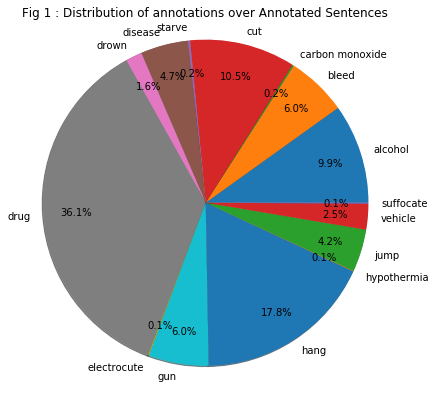

In [442]:
# The slices will be ordered and plotted counter-clockwise.
labels = sorted(dict_annot, key=dict_annot.get)
sizes = counter
#explode=(0, 0.05, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0)
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red','blue','green']
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0,0,1,1))
plt.title('Fig 1 : Distribution of annotations over Annotated Sentences')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, pctdistance=0.8, labeldistance=1.08, radius = 4)
plt.axis('equal')
plt.savefig('C:/Users/AshwinAmbal/Desktop/Project Plots Pics//Pie_Distribution.png',dpi=200, bbox_inches='tight')
plt.show()